# Horse vs Human classifier

In [15]:
from keras_preprocessing.image import ImageDataGenerator,img_to_array, load_img
from keras_preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras_preprocessing
import tensorflow as tf
import numpy as np
import zipfile
import tarfile
import random
import numpy
import keras
import wget
import os

print("Libraries imported successfully!")

Libraries imported successfully!


### Downloading data

In [2]:
def download_wget(URLS, FILE_EXT, DIR_PATH):
    for url in URLS:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(DIR_PATH):
            print('Downloading', url)
            wget.download(url, out=DIR_PATH)
            file_path = os.path.join(DIR_PATH, target_file)
            
            print('\n \nExtracting files from', file_path)
            if FILE_EXT == '.zip':
                zip_ref = zipfile.ZipFile(file_path,'r')
                zip_ref.extractall(DIR_PATH)
                zip_ref.close()
                os.remove(file_path)

if not os.path.isdir('Data'):
    os.mkdir('Data')     

In [3]:
DATA_URLS = ['https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip']
DIR_NAME = 'horse-vs-human'

if not os.path.isdir('Data/' + DIR_NAME):
    os.mkdir('Data/' + DIR_NAME)  
    
DATA_FILE_EXT = '.zip'
DATA_DIR_PATH = './Data/' + DIR_NAME

download_wget(DATA_URLS, DATA_FILE_EXT, DATA_DIR_PATH)

100% [......................................................................] 149574867 / 149574867
 
Extracting files from ./Data/horse-vs-human\horse-or-human.zip


In [4]:
DATA_URLS = ['https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip']
DIR_NAME = 'validation-horse-vs-human'

if not os.path.isdir('Data/' + DIR_NAME):
    os.mkdir('Data/' + DIR_NAME)  
    
DATA_FILE_EXT = '.zip'
DATA_DIR_PATH = './Data/' + DIR_NAME

download_wget(DATA_URLS, DATA_FILE_EXT, DATA_DIR_PATH)

100% [........................................................................] 11480187 / 11480187
 
Extracting files from ./Data/validation-horse-vs-human\validation-horse-or-human.zip


### Dataset info

In [5]:
class1 = 'horses'
class2 = 'humans'

train_dir = 'horse-vs-human'
validation_dir = 'validation-horse-vs-human'

train_dir_path = './data/'+ train_dir + '/'
validation_dir_path = './data/'+ validation_dir + '/'

# Directories with the training images
train_class1_dir = os.path.join('./data/'+ train_dir + '/' + class1)
train_class2_dir = os.path.join('./data/'+ train_dir + '/' + class2)

# Directories with the validation images
validation_class1_dir = os.path.join('./data/'+ validation_dir + '/' + class1)
validation_class2_dir = os.path.join('./data/'+ validation_dir + '/' + class2)

We check how many images for training and validating

In [6]:
# Total number of training pictures
print('\nTotal training horse images:', len(os.listdir(train_class1_dir)))
print('Total training human images:', len(os.listdir(train_class2_dir)))

# Total number of training pictures
print('\nTotal validation horse images:', len(os.listdir(validation_class1_dir)))
print('Total validation human images:', len(os.listdir(validation_class2_dir)))


Total training horse images: 500
Total training human images: 527

Total validation horse images: 128
Total validation human images: 128


We will output images of horses and humans in a 4x4 configuration

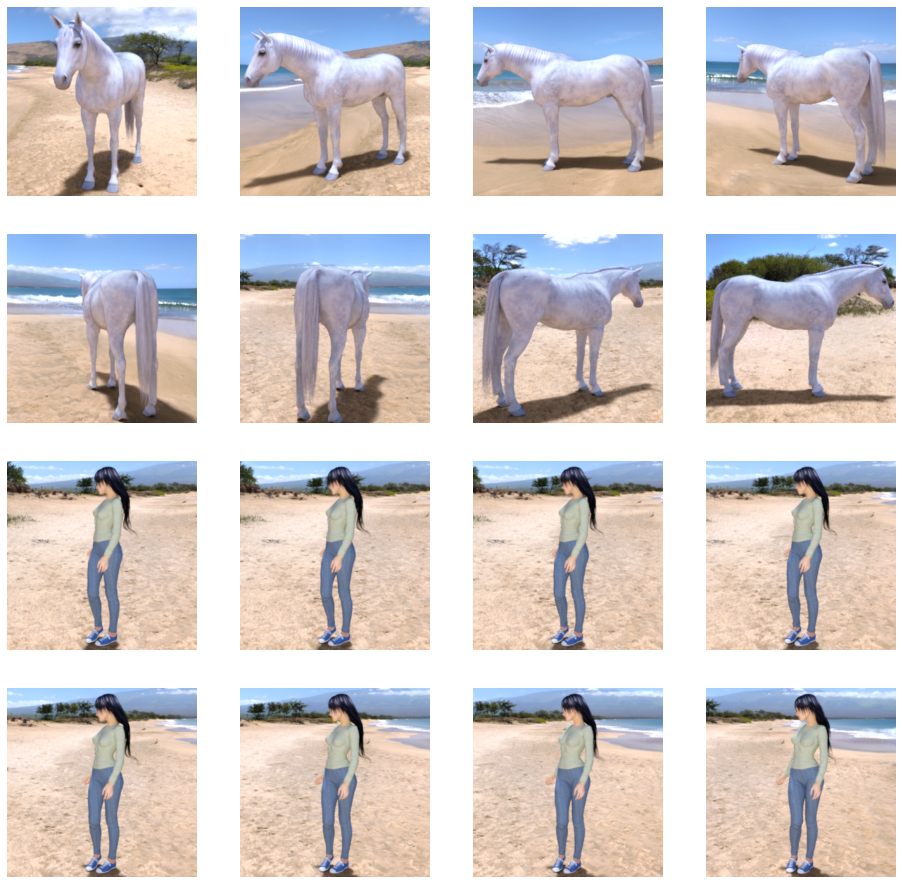

In [7]:
train_class1_names = os.listdir(train_class1_dir)
train_class2_names = os.listdir(train_class2_dir)
validation_class1_names = os.listdir(validation_class1_dir)
validation_class2_names = os.listdir(validation_class2_dir)


nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_class1_pix = [os.path.join(train_class1_dir, fname) 
                for fname in train_class1_names[pic_index-8:pic_index]]
next_class2_pix = [os.path.join(train_class2_dir, fname) 
                for fname in train_class2_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_class1_pix+next_class2_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### Train the model | Create a CNN

The trainning images are **normalized**, and besides training the original image, it will train the same image with zoom, making a horizontal flip, rotating it, etc. 

By means of the operation **flow_from_directory**, we specify it to use the specified directory as base and the labels will be the names of the subdirectories of the same one.

In [8]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir_path,                             # Source directory for training images
        target_size=(300, 300),                     # All images will be resized to 300x300
        batch_size=128,
        class_mode='binary')                        # Since we use binary_crossentropy loss, we need binary labels

# Flow validation images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir_path,                        # Source directory for validation images
        target_size=(300, 300),                     # All images will be resized to 300x300
        batch_size=32,
        class_mode='binary')                        # Since we use binary_crossentropy loss, we need binary labels


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


We define the model using convultions and polling:
- Convolution: technique to reduce the amount of information, they then allowed the neural network to effectively extract features 
- Pooling: technique to compress the information to make it more manageable.
    

In [9]:
model = tf.keras.models.Sequential([
    
    # Convolutions
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')])

See the summary of the model

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

We define a **Callback** class that stops training once accuracy reaches 97.0%

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
        
callbacks = myCallback()

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Epoch 1/15
8/8 [==============================] - 139s 18s/step - loss: 0.8019 - accuracy: 0.5630 - val_loss: 0.6043 - val_accuracy: 0.7578
Epoch 2/15
8/8 [==============================] - 148s 18s/step - loss: 0.6049 - accuracy: 0.7533 - val_loss: 0.9120 - val_accuracy: 0.7070
Epoch 3/15
8/8 [==============================] - 113s 13s/step - loss: 0.4071 - accuracy: 0.8015 - val_loss: 0.9519 - val_accuracy: 0.8477
Epoch 4/15
8/8 [==============================] - 102s 13s/step - loss: 0.2084 - accuracy: 0.9263 - val_loss: 1.3686 - val_accuracy: 0.8633
Epoch 5/15
8/8 [==============================] - 130s 16s/step - loss: 0.3635 - accuracy: 0.8538 - val_loss: 0.8268 - val_accuracy: 0.7461
Epoch 6/15
8/8 [==============================] - 105s 13s/step - loss: 0.3751 - accuracy: 0.8326 - val_loss: 0.4317 - val_accuracy: 0.8672
Epoch 7/15
8/8 [==============================] - 92s 13s/step - loss: 0.1473 - accuracy: 0.9489 - val_loss: 2.0054 - val_accuracy: 0.8008
Epoch 8/15
8/8 [=====

Lets try with an random image recently downloaded, we will check if the **model is classifying properly** the image.

./data/experiment/whoknows.png is a horses


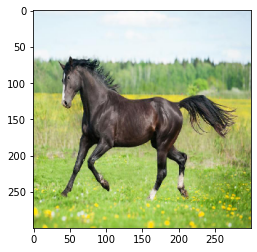

In [16]:
file = './data/experiment/whoknows.png'

img = image.load_img(file, target_size=(300, 300))
plt.imshow(img) 

x = image.img_to_array(img) # (300, 300, 3)
x = np.expand_dims(x, axis=0) # (1, 300, 300, 3)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

if classes[0]<0.5:
    print(file + " is a " + class1)
else:
    print(file + " is a " + class2)

### Accuracy and loss plot

Show grapich about **accuracy and loss** during the different epochs.

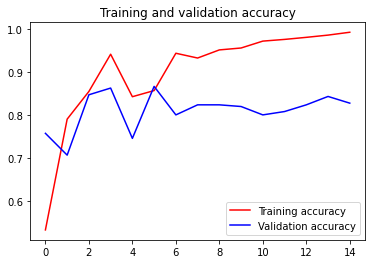

<Figure size 432x288 with 0 Axes>

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

### Visualizing Intermediate Representations

To get closer to what features our CNN has learned, one interesting thing to do is to visualize how an input gets transformed as it goes through the model.

<ipython-input-20-3bf76b97e3ed>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


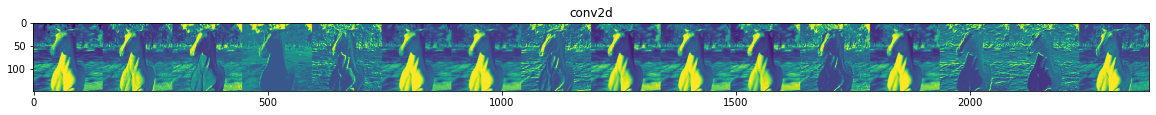

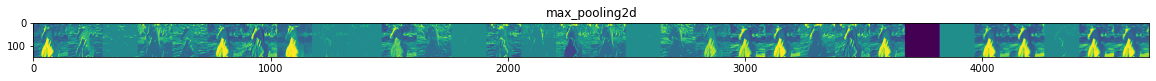

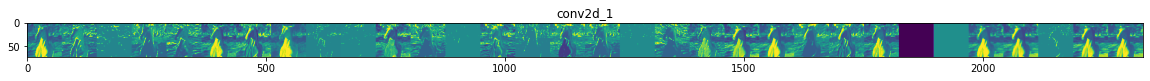

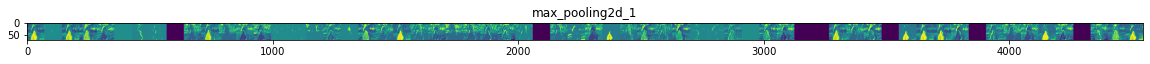

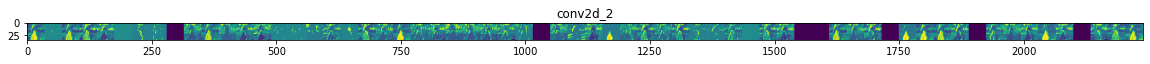

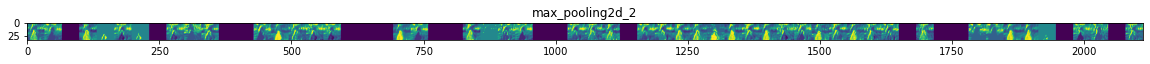

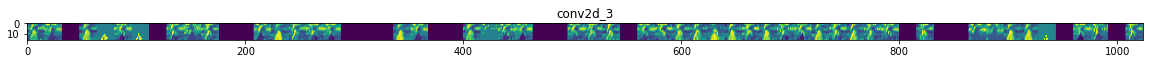

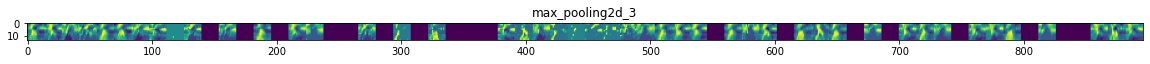

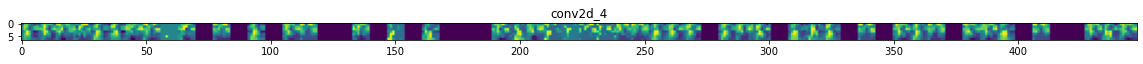

In [20]:
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_class1_dir, f) for f in train_class1_names]
human_img_files = [os.path.join(train_class2_dir, f) for f in train_class2_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')